In [120]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [121]:
import pandas as pd

df = pd.read_csv("data/ExtractedTweets.csv")

democrat = df.query("Party == 'Democrat'").sample(20000)
republican = df.query("Party == 'Republican'").sample(20000)

df_slim = democrat.append(republican)
df_slim.head()
df = df_slim

### Extract tweet information

In [122]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [123]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\-.,;:!/?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)

print("Cleaned tweets")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dslh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned tweets


### Lemmatize the text

In [124]:
import spacy
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
print("Lemmatized tweets")

Lemmatized tweets


In [125]:
import gensim

def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)

print("Generated tokens")

Generated tokens


In [126]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)

print("Generated trigrams")

Generated trigrams


### TF-IDF REMOVAL

In [127]:
from gensim.models import TfidfModel
import gensim.corpora as corpora
from sklearn.model_selection import train_test_split

id2word = corpora.Dictionary(df['trigrams'])

# split train and test data to use different lda models later
text_train, text_test, label_train, label_test = train_test_split(df["trigrams"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)

corpus_train = [id2word.doc2bow(text) for text in text_train]
corpus_test = [id2word.doc2bow(text) for text in text_test]
tfidf_train = TfidfModel(corpus_train, id2word=id2word)
tfidf_test = TfidfModel(corpus_test, id2word=id2word)

removed_words  = []
def tf_idf(corpus):
    low_value = 0.15
    words_missing_in_tfidf = []
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = [] # reinitialize to be safe.
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for item in drops:
            removed_words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # words with tf-idf score 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
    # remove empty entries
    corpus = [x for x in corpus if x != []]
    return corpus

corpus_train = tf_idf(corpus_train)
corpus_test = tf_idf(corpus_test)

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


Text(0.5, 1.0, 'Words removed from individual tweets proportional by their size.')

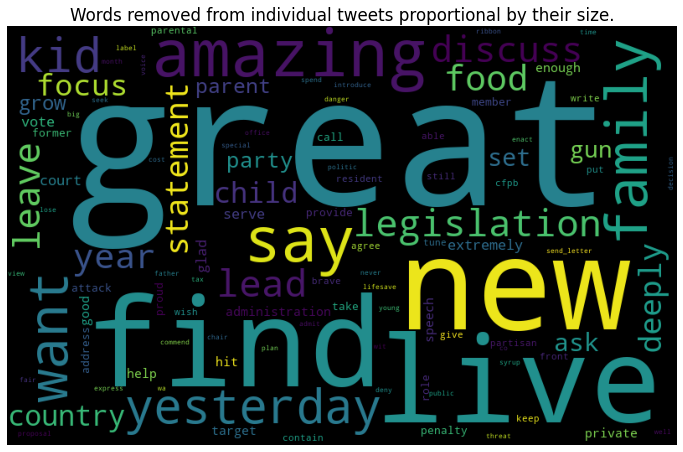

In [97]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(collocations=False, width = 800, height = 500).generate(" ".join(removed_words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Words removed from individual tweets proportional by their size.")

In [34]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

In [130]:
import gensim
corpus_train = tf_idf(corpus_train)
corpus_test = tf_idf(corpus_test)

lda_model_train = gensim.models.LdaMulticore(
                corpus=corpus_train[:-1],
                id2word=id2word,
                num_topics=10,
                random_state=123,
                per_word_topics=False,
                workers=7
            )

lda_model_test = gensim.models.LdaMulticore(
                corpus=corpus_test[:-1],
                id2word=id2word,
                num_topics=10,
                random_state=123,
                per_word_topics=False,
                workers=7
            )

Confusion:
 [[4031 1860]
 [4040 2069]]
Accuracy: 0.5083333333333333
Precision: 0.5130197733849676
Recall: 0.5114723834274306
F1Score: 0.49482897520577795


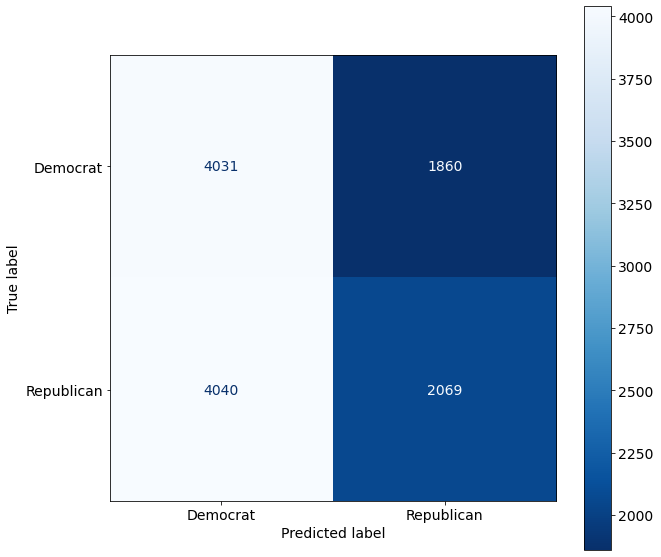

In [131]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
text_train = pd.DataFrame(text_train)
text_test = pd.DataFrame(text_test)
text_train['topic_vec'] = text_train['trigrams'].apply(lambda trigram: get_document_topic(lda_model_train, trigram))
text_test['topic_vec'] = text_test['trigrams'].apply(lambda trigram: get_document_topic(lda_model_test, trigram))

cl = MLPClassifier()

# Train and predict
cl.fit(text_train['topic_vec'].tolist(), label_train)
prediction = cl.predict(text_test['topic_vec'].tolist())

# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion:\n " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))

# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test['topic_vec'].tolist(), label_test, ax=ax_cm, cmap=plt.cm.Blues_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_130.pdf")
plt.show()

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model_test, corpus, id2word, mds="mmds", R=30)
vis